# Degeneracy Detection on Planck 2018 ΛCDM Chains

Visualize degeneracy detector results on Planck 2018 base ΛCDM posterior samples (TTTEEE+lowl+lowE+lensing).

**To run the analysis**, use the script (pick 1.0 to disable early stopping):
```bash
python3 /home/x-ctirapongpra/scratch/degen_detector/scripts/run_planck_analysis.py --output-dir /home/x-ctirapongpra/scratch/degen_detector/outputs/planck --r2-threshold 1.0
```

This notebook only handles plotting.

In [1]:
try:
    import dill as pickle  # dill can unpickle lambdas
except ImportError:
    import pickle
from pathlib import Path

import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 14, 'figure.figsize': (15, 5)})

## 1. Load Results

In [2]:
# Load results - update this path to your run
RESULTS_DIR = Path("/home/x-ctirapongpra/scratch/degen_detector/outputs/planck")

# Find the latest run directory
run_dirs = sorted(RESULTS_DIR.glob("*"), key=lambda p: p.name, reverse=True)
if run_dirs:
    latest_run = run_dirs[0]
    print(f"Loading results from: {latest_run}")
else:
    raise FileNotFoundError(f"No results found in {RESULTS_DIR}. Run the analysis script first.")

sys.path.insert(0, '/anvil/scratch/x-ctirapongpra/degen_detector/')
from degen_detector import DegenDetector
from degen_detector.plotting import plot_corner_with_degeneracy, plot_residual_corner

with open(latest_run / "planck_result.pkl", "rb") as f:
    result = pickle.load(f)

samples = result['samples']
param_names = result['param_names']
results = result['results']

print(f'Samples shape: {samples.shape}')
print(f'Parameters: {param_names}')
print(f'\nMeans:')
for i, p in enumerate(param_names):
    print(f'  {p:>10s} = {np.mean(samples[:, i]):.5f} ± {np.std(samples[:, i]):.5f}')

Loading results from: /home/x-ctirapongpra/scratch/degen_detector/outputs/planck/20260226_104838
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Samples shape: (25225, 6)
Parameters: ['omegam', 'H0', 'sigma8', 'ns', 'tau', 'logA']

Means:
      omegam = 0.31531 ± 0.00737
          H0 = 67.35755 ± 0.53881
      sigma8 = 0.81119 ± 0.00602
          ns = 0.96489 ± 0.00417
         tau = 0.05437 ± 0.00736
        logA = 3.04448 ± 0.01424


## 2. Summary of Discovered Degeneracies

In [3]:
print(f'Fits attempted: {results.n_fits_attempted}/{results.n_fits_total}')
print(f'Early stop: {results.stopped_early}')

# Show all successful fits ranked by R²
successful = [f for f in results.fits if f.fit is not None]
successful.sort(key=lambda f: f.fit.r_squared, reverse=True)

print(f'\nSuccessful fits: {len(successful)}')
for i, cf in enumerate(successful):
    print(f'  {i+1}. {cf.fit.equation_str}')
    print(f'     R² = {cf.fit.r_squared:.4f}, MI = {cf.mi_score:.3f}')

Fits attempted: 20/20
Early stop: False

Successful fits: 20
  1. omegam = -0.59601486 - (-61.381207 / H0)
     R² = 0.9833, MI = 0.108
  2. omegam = (61.76333 / H0) - 0.6016906
     R² = 0.9833, MI = 0.314
  3. omegam = (61.774654 / H0) - 0.6017914
     R² = 0.9833, MI = 0.055
  4. omegam = (61.147 / H0) + -0.59248525
     R² = 0.9832, MI = 0.060
  5. logA = (exp(sigma8) - omegam) + 1.1091765
     R² = 0.9574, MI = 0.056
  6. logA = sigma8 + log((H0 * 0.17077793) * sigma8)
     R² = 0.9451, MI = 0.055
  7. logA = (tau + 2.1789448) + sigma8
     R² = 0.9107, MI = 0.317
  8. tau = (logA * 0.47177073) + -1.3819335
     R² = 0.8496, MI = 0.063
  9. tau = 1.5311666 - (4.496356 / logA)
     R² = 0.8491, MI = 0.060
  10. tau = 1.5071757 - (4.422328 / logA)
     R² = 0.8489, MI = 0.057
  11. tau = sigma8 + (-0.19532445 - sqrt(omegam))
     R² = 0.7820, MI = 0.056
  12. tau = sigma8 + (-50.988926 / H0)
     R² = 0.7797, MI = 0.055
  13. logA = exp(sigma8) + 0.7938861
     R² = 0.6686, MI = 0.0

## 3. Mutual Information Heatmap

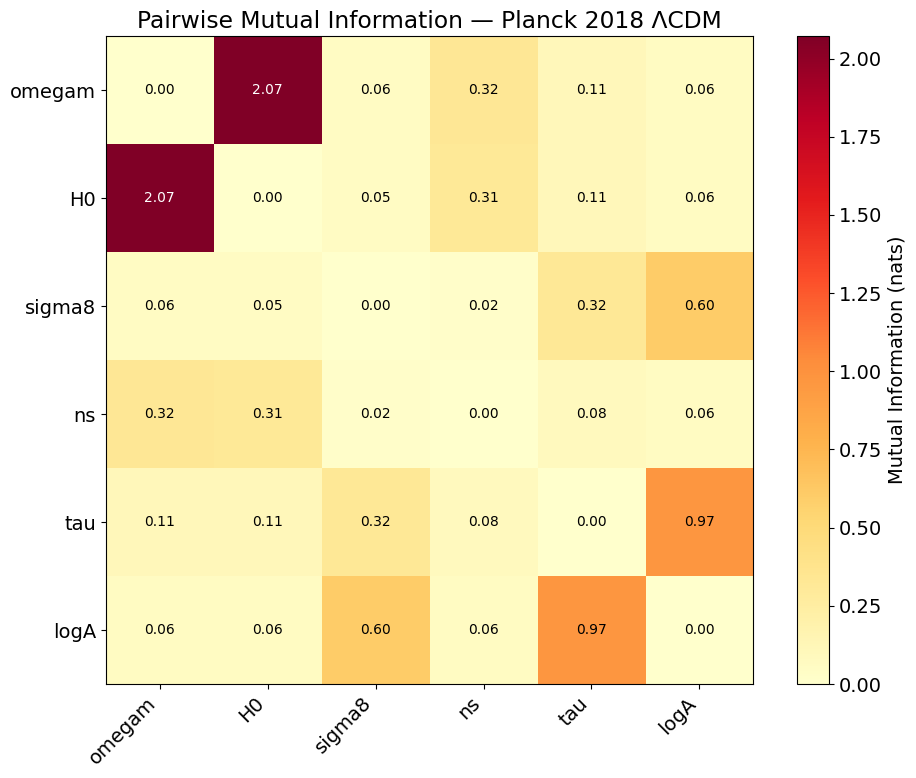

In [4]:
mi = results.mi_result.mi_matrix
names = results.mi_result.param_names

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(mi, cmap='YlOrRd')
ax.set_xticks(range(len(names)))
ax.set_yticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_yticklabels(names)

# Annotate cells
for i in range(len(names)):
    for j in range(len(names)):
        ax.text(j, i, f'{mi[i,j]:.2f}', ha='center', va='center',
                color='white' if mi[i,j] > mi.max()/2 else 'black', fontsize=10)

plt.colorbar(im, label='Mutual Information (nats)')
ax.set_title('Pairwise Mutual Information — Planck 2018 ΛCDM')
plt.tight_layout()
plt.show()

## 4. Parameter Scatter Plots with Discovered Equations

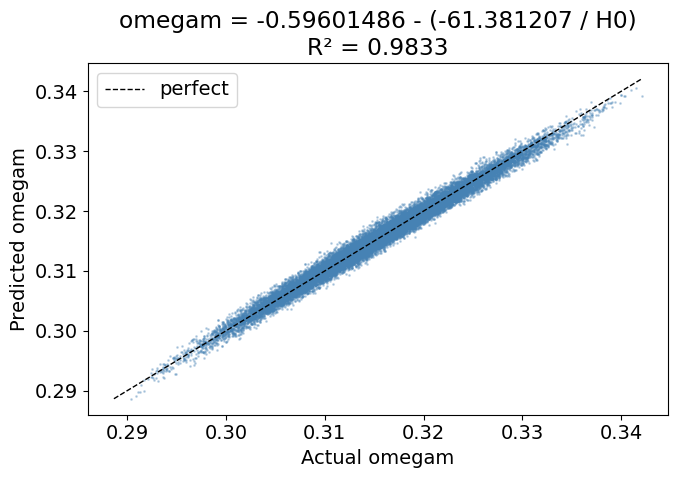

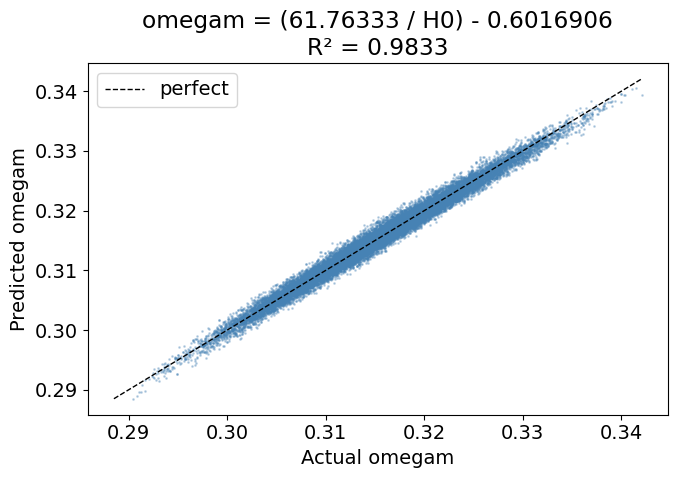

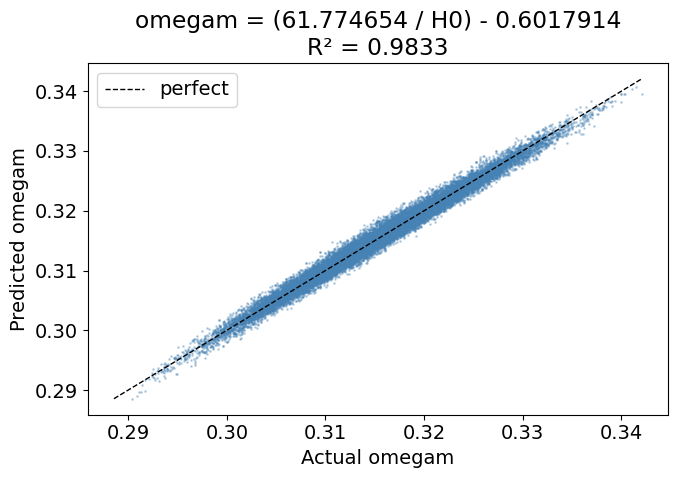

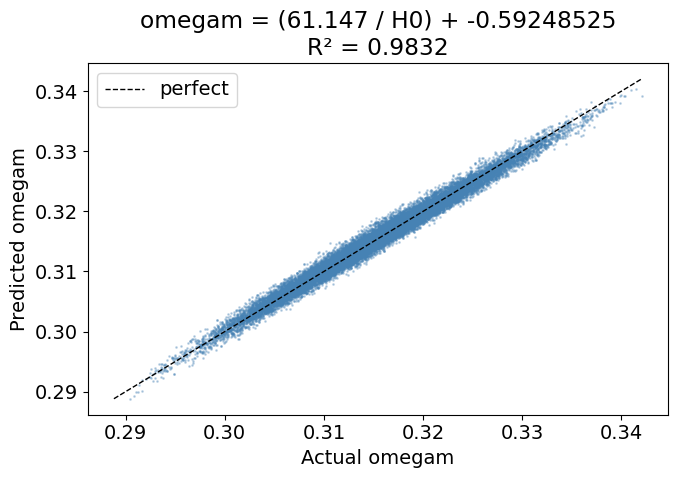

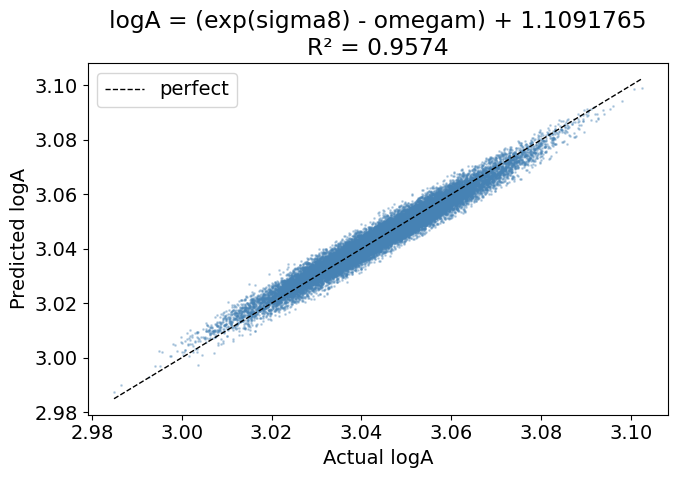

In [5]:
# Plot top fits (successful fits already sorted by R² in previous cell)
for cf in successful[:5]:  # Show top 5 fits
    fit = cf.fit

    # Get input and target data
    target_idx = param_names.index(fit.target_name)
    input_indices = [param_names.index(n) for n in fit.input_names]
    y_actual = samples[:, target_idx]
    X_input = samples[:, input_indices]
    y_pred = fit.predict(X_input)

    if len(fit.input_names) == 1:
        # 2D scatter: input vs target
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Left: raw scatter
        ax = axes[0]
        ax.scatter(X_input[:, 0], y_actual, s=1, alpha=0.3, c='steelblue')
        # Overlay predicted curve
        sort_idx = np.argsort(X_input[:, 0])
        ax.plot(X_input[sort_idx, 0], y_pred[sort_idx], 'r-', lw=2,
                label=fit.equation_str)
        ax.set_xlabel(fit.input_names[0])
        ax.set_ylabel(fit.target_name)
        ax.legend(fontsize=10)
        ax.set_title(f'Discovered: {fit.equation_str}')

        # Right: predicted vs actual
        ax = axes[1]
        ax.scatter(y_actual, y_pred, s=1, alpha=0.3, c='steelblue')
        lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
        ax.plot(lims, lims, 'k--', lw=1, label='perfect')
        ax.set_xlabel(f'Actual {fit.target_name}')
        ax.set_ylabel(f'Predicted {fit.target_name}')
        ax.set_title(f'R² = {fit.r_squared:.4f}')
        ax.legend()

    else:
        # Multi-input: predicted vs actual only
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.scatter(y_actual, y_pred, s=1, alpha=0.3, c='steelblue')
        lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
        ax.plot(lims, lims, 'k--', lw=1, label='perfect')
        ax.set_xlabel(f'Actual {fit.target_name}')
        ax.set_ylabel(f'Predicted {fit.target_name}')
        ax.set_title(f'{fit.equation_str}\nR² = {fit.r_squared:.4f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

## 5. Corner Plots with Degeneracy Highlighting

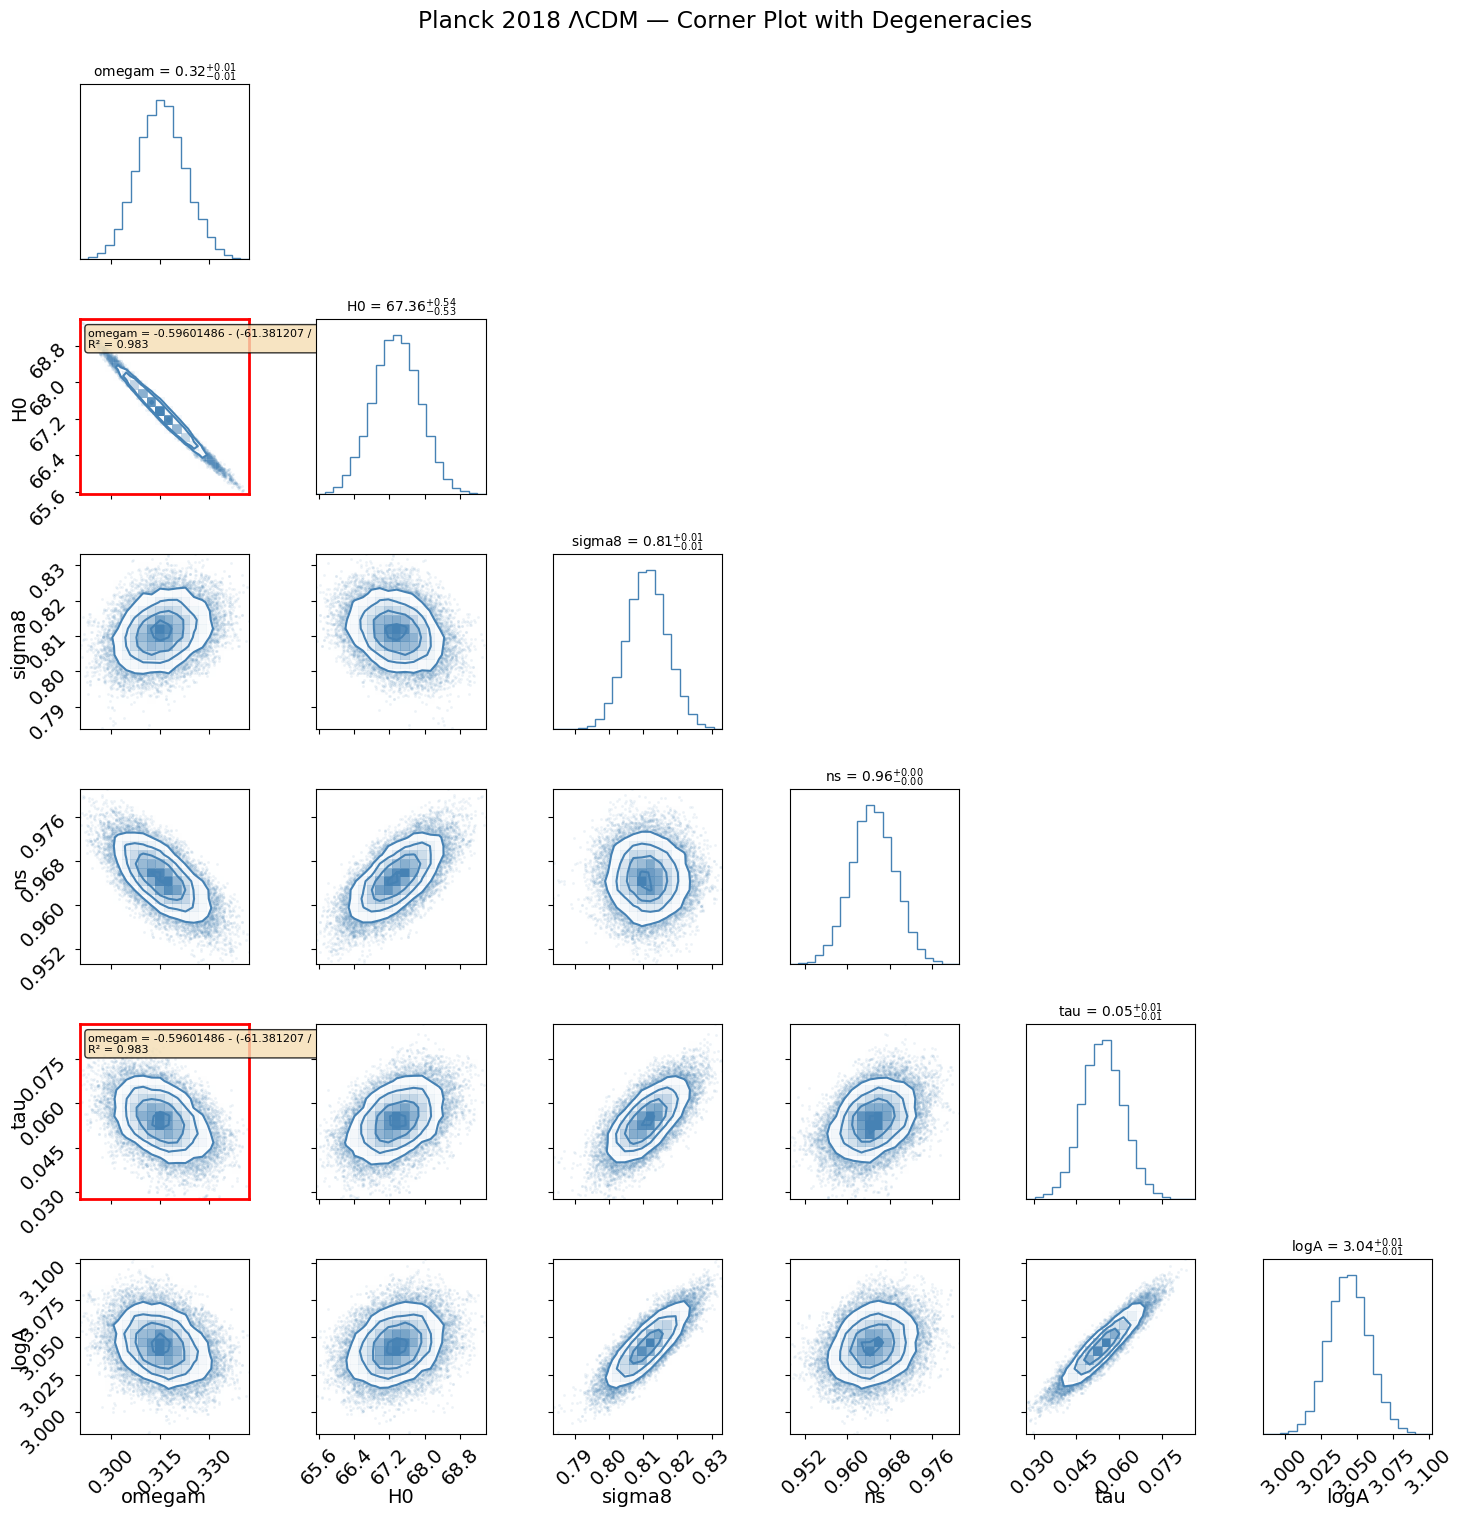

In [6]:
# Corner plot with discovered degeneracies highlighted
fig = plot_corner_with_degeneracy(
    samples,
    param_names,
    results,
    color='steelblue'
)
fig.suptitle('Planck 2018 ΛCDM — Corner Plot with Degeneracies', y=1.02)
plt.show()

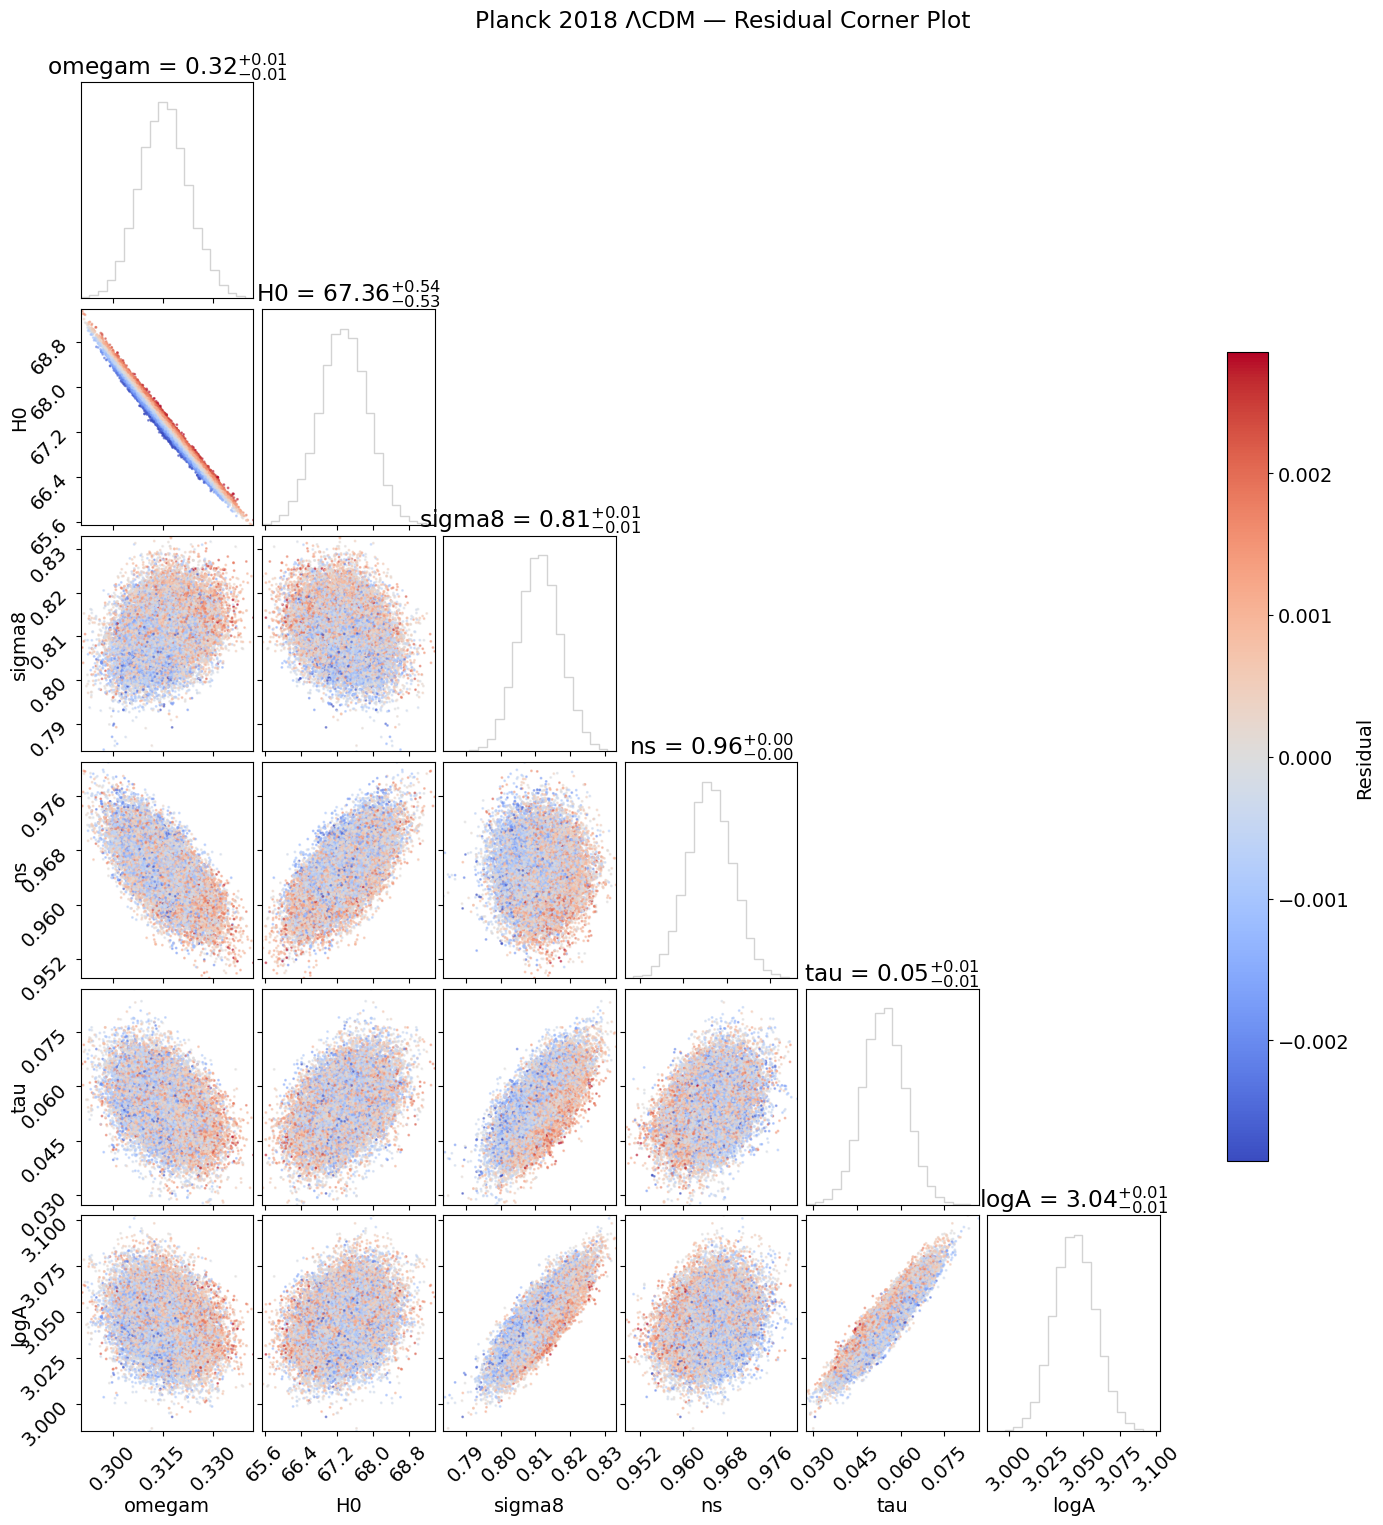

In [7]:
# Residual-colored corner plot - shows where the best fit equation fits well vs poorly
fig = plot_residual_corner(
    samples,
    param_names,
    results.best_fit.fit
)
fig.suptitle('Planck 2018 ΛCDM — Residual Corner Plot', y=1.02)
plt.show()